Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [91]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [92]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [93]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/data/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/data/Test')

In [94]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2244
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [95]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [96]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 6744 files belonging to 9 classes.
Using 5396 files for training.


In [97]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 6744 files belonging to 9 classes.
Using 1348 files for validation.


In [98]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

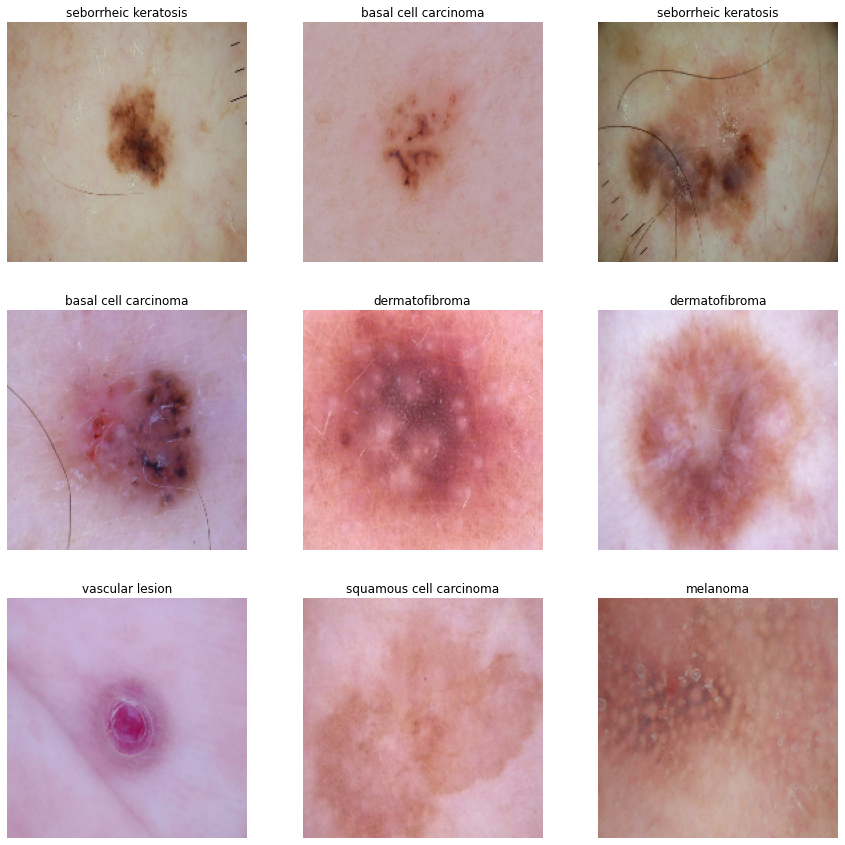

In [99]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15, 15))

for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [100]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [101]:
from keras.layers import  Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization

normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization(x), layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization(x), layer(y)))

In [102]:
### Your code goes here


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))

model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))

model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(9))
model.add(Activation('softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [103]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [104]:
# View the summary of all layers
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_31 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 88, 88, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 88, 88, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 88, 88, 64)        36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 44, 44, 64)       0         
 g2D)                                                 

### Train the model

In [105]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
169/169 [==============================] - 45s 138ms/step - loss: 1.9154 - accuracy: 0.2583 - val_loss: 1.8193 - val_accuracy: 0.2767
Epoch 2/20
169/169 [==============================] - 13s 77ms/step - loss: 1.5537 - accuracy: 0.4072 - val_loss: 1.4856 - val_accuracy: 0.4496
Epoch 3/20
169/169 [==============================] - 13s 78ms/step - loss: 1.3052 - accuracy: 0.5026 - val_loss: 1.2848 - val_accuracy: 0.5045
Epoch 4/20
169/169 [==============================] - 13s 79ms/step - loss: 1.1220 - accuracy: 0.5814 - val_loss: 1.1994 - val_accuracy: 0.5942
Epoch 5/20
169/169 [==============================] - 14s 80ms/step - loss: 0.8912 - accuracy: 0.6731 - val_loss: 1.0014 - val_accuracy: 0.6513
Epoch 6/20
169/169 [==============================] - 14s 80ms/step - loss: 0.6177 - accuracy: 0.7832 - val_loss: 0.8424 - val_accuracy: 0.7433
Epoch 7/20
169/169 [==============================] - 13s 79ms/step - loss: 0.4251 - accuracy: 0.8467 - val_loss: 1.0277 - val_accuracy

### Visualizing training results

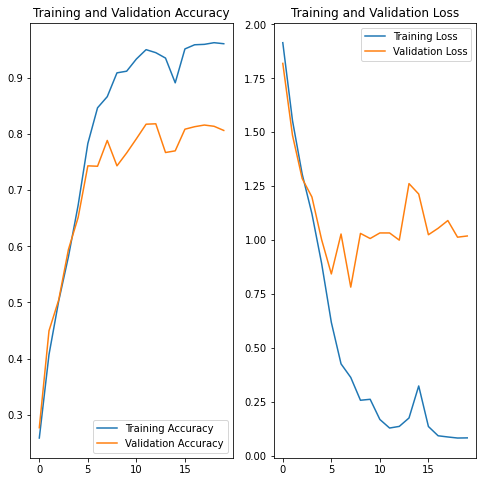

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
### Findings

#### Models works on training set very well but fails on validation set. Accurancy on validation set is way less than validation set which is a clear case of Overfitting.

In [107]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal',
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


### Todo:
### Create the model, compile and train the model


In [108]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here


model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))

model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))

model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(9))
model2.add(Activation('softmax'))

### Compiling the model

In [109]:
## Your code goes here
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 activation_43 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 conv2d_35 (Conv2D)          (None, 176, 176, 64)      18496     
                                                                 
 activation_44 (Activation)  (None, 176, 176, 64)      0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 88, 88, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 86, 86, 64)        36928     
                                                     

### Training the model

In [110]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)



Epoch 1/20
169/169 [==============================] - 22s 124ms/step - loss: 2.1817 - accuracy: 0.1464 - val_loss: 2.1610 - val_accuracy: 0.1647
Epoch 2/20
169/169 [==============================] - 19s 115ms/step - loss: 1.8625 - accuracy: 0.2771 - val_loss: 1.6933 - val_accuracy: 0.3390
Epoch 3/20
169/169 [==============================] - 19s 115ms/step - loss: 1.5967 - accuracy: 0.3834 - val_loss: 1.5158 - val_accuracy: 0.4006
Epoch 4/20
169/169 [==============================] - 19s 115ms/step - loss: 1.3866 - accuracy: 0.4607 - val_loss: 1.2784 - val_accuracy: 0.5200
Epoch 5/20
169/169 [==============================] - 19s 115ms/step - loss: 1.1613 - accuracy: 0.5589 - val_loss: 1.1016 - val_accuracy: 0.6016
Epoch 6/20
169/169 [==============================] - 19s 115ms/step - loss: 0.9476 - accuracy: 0.6440 - val_loss: 0.9227 - val_accuracy: 0.6654
Epoch 7/20
169/169 [==============================] - 19s 115ms/step - loss: 0.7635 - accuracy: 0.7237 - val_loss: 0.8926 - val_ac

### Visualizing the results

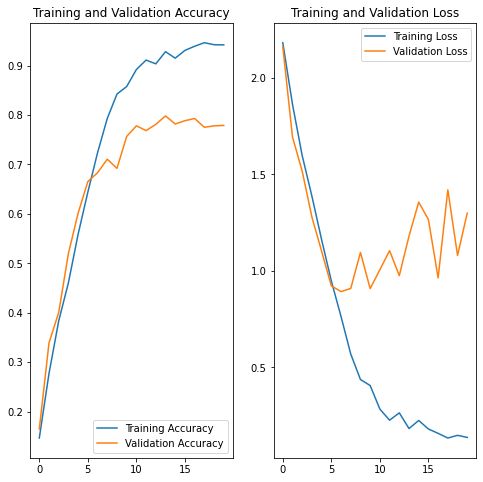

In [111]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Training and validation accuracy is very less  which means model has not learned and it is case of underfiting now.  There is no improvement in model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

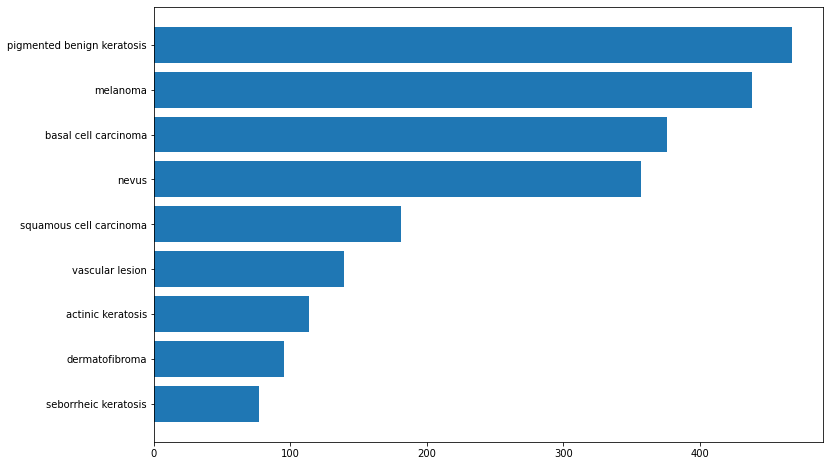

In [112]:
## Your code goes here.
count = {}

for i in class_names:
    count[i] = len(list(data_dir_train.glob(f'{i}/*.jpg')))

count = dict(sorted(count.items(), key=lambda x: x[1]))

count_list = list(count.items())
x, y = zip(*count_list)

plt.figure(figsize=(12, 8))
plt.barh(x, y)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
* Seborrheic Keratosis

#### - Which classes dominate the data in terms proportionate number of samples?
* Pigmented Benign Keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [113]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [114]:
path_to_training_dataset="/content/gdrive/My Drive/Colab Notebooks/data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1BDAA3D050>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1BDA9DBA10>: 100%|██████████| 500/500 [00:19<00:00, 25.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1BDAB61210>: 100%|██████████| 500/500 [00:22<00:00, 22.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=961x649 at 0x7F1BFC08BC50>: 100%|██████████| 500/500 [01:39<00:00,  5.01 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F1BDA246090>: 100%|██████████| 500/500 [01:24<00:00,  5.91 Samples/s]


Initialised with 467 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1BDACE6510>: 100%|██████████| 500/500 [00:17<00:00, 28.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1BFF1E4FD0>: 100%|██████████| 500/500 [00:40<00:00, 12.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1BDA362D50>: 100%|██████████| 500/500 [00:17<00:00, 27.84 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1BDAD46A90>: 100%|██████████| 500/500 [00:18<00:00, 27.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [115]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [116]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[0]

'/content/gdrive/My Drive/Colab Notebooks/data/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025264.jpg_29b26be1-eeac-4e87-9feb-35b7749cdf2a.jpg'

In [117]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(list(set(lesion_list_new)))

['squamous cell carcinoma', 'dermatofibroma', 'nevus', 'actinic keratosis', 'seborrheic keratosis', 'vascular lesion', 'pigmented benign keratosis', 'melanoma', 'basal cell carcinoma']


In [118]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
dataframe_dict = dict(zip(path_list_new, lesion_list_new))

In [119]:
original_df = pd.DataFrame(list(dataframe_dict.items()), columns=['Path', 'Label'])
original_df['Label'].value_counts()

squamous cell carcinoma       1000
vascular lesion               1000
dermatofibroma                1000
melanoma                      1000
actinic keratosis             1000
seborrheic keratosis          1000
basal cell carcinoma          1000
nevus                         1000
pigmented benign keratosis    1000
Name: Label, dtype: int64

In [120]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [121]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [122]:
new_df['Label'].value_counts()

squamous cell carcinoma       2000
vascular lesion               2000
dermatofibroma                2000
melanoma                      2000
actinic keratosis             2000
seborrheic keratosis          2000
basal cell carcinoma          2000
nevus                         2000
pigmented benign keratosis    2000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [123]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [124]:
data_dir_train="/content/gdrive/My Drive/Colab Notebooks/data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11244 files belonging to 9 classes.
Using 8996 files for training.


#### **Todo:** Create a validation dataset

In [125]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11244 files belonging to 9 classes.
Using 2248 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [126]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization(x), layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization(x), layer(y)))

model3 = Sequential( 
    [layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])

## simple model works better with more data

model3.add(Conv2D(16, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(32, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(64, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.20))

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dense(9))
model3.add(Activation('softmax'))



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [127]:
## your code goes here
model3.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])




#### **Todo:**  Train your model

In [128]:
epochs = 50
## Your code goes here, use 50 epochs.
history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
282/282 [==============================] - 64s 65ms/step - loss: 1.8131 - accuracy: 0.3000 - val_loss: 1.4531 - val_accuracy: 0.4488
Epoch 2/50
282/282 [==============================] - 8s 28ms/step - loss: 1.3963 - accuracy: 0.4707 - val_loss: 1.3999 - val_accuracy: 0.5062
Epoch 3/50
282/282 [==============================] - 8s 28ms/step - loss: 1.2314 - accuracy: 0.5323 - val_loss: 1.5014 - val_accuracy: 0.4622
Epoch 4/50
282/282 [==============================] - 8s 28ms/step - loss: 1.1160 - accuracy: 0.5801 - val_loss: 1.1574 - val_accuracy: 0.5614
Epoch 5/50
282/282 [==============================] - 8s 28ms/step - loss: 1.0298 - accuracy: 0.6172 - val_loss: 1.0606 - val_accuracy: 0.6201
Epoch 6/50
282/282 [==============================] - 8s 28ms/step - loss: 0.9305 - accuracy: 0.6511 - val_loss: 1.0710 - val_accuracy: 0.6108
Epoch 7/50
282/282 [==============================] - 8s 28ms/step - loss: 0.8942 - accuracy: 0.6634 - val_loss: 0.7955 - val_accuracy: 0.717

#### **Todo:**  Visualize the model results

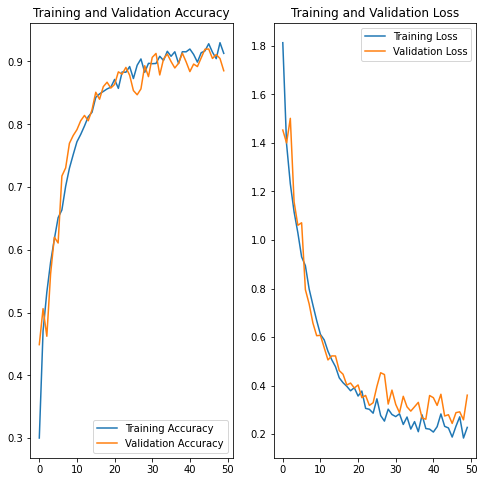

In [129]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
After rebalancing of the class the accuracy on the validation set has shown major improvement, the validation set now shows 86.6% accuracy. This confirms that class rebalance helped in dealing with the underfitting that was present after using dropouts to deal with overfitting.



# Model Performance on test dataset

In [130]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size,
    color_mode='rgb'
)

Found 118 files belonging to 9 classes.


In [131]:
test_ds = test_ds.map(lambda x, y: (normalization(x), layer(y)))

In [132]:
loss , accuracy = model3.evaluate(test_ds)

4/4 [==============================] - 3s 13ms/step - loss: 8.8823 - accuracy: 0.3644


## Prediction on New Test Data

In [133]:
y_pred= model3.fit(test_ds)

4/4 [==============================] - 3s 30ms/step - loss: 8.3507 - accuracy: 0.3729


In [134]:
img_path = "/content/gdrive/My Drive/Colab Notebooks/data/Test/melanoma/ISIC_0000056.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model3.predict(img_array)
score = tf.nn.softmax(predictions)

print(score)

tf.Tensor(
[[0.09329855 0.09329855 0.09329855 0.2536117  0.09329855 0.09329855
  0.09329855 0.09329855 0.09329855]], shape=(1, 9), dtype=float32)


In [135]:
class_names[np.argmax(score)]

'melanoma'